# CESM-LE analysis
### Looks snow melt dynamics from individual grid cells
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily SNOWDP & QRUNOFF over water year (Oct - Sept)
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait

%matplotlib inline

In [2]:
print('xarray '+xr.__version__) ## was working with 17.0
print('dask '+dask.__version__) ## was working with 2021.02.0

xarray 0.17.0
dask 2021.02.0


### run this cell to check if you have LENS2 read access:

In [3]:
samplefile = ('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/'+
              'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [4]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient(nmem='50GB')
cluster.scale(40)

In [6]:
cluster

In [7]:
#client.restart()
#cluster.close()

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [9]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [10]:
def get_file(model,mem,field,year,freq='monthly',component='lnd'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq,component)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [11]:
def all_files(model,ens,field,firstyear,lastyear,
              freq='monthly',component='lnd'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq,component)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [12]:
def get_data(model,ens,fields,firstyear,lastyear,freq,
             component='lnd',chunks={'time':1000},
            ):#Preprocess=False,plat=None,plon=None):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key 
            e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, 
            and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset
    
    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,
                              freq,component)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']

        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                       concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [13]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [14]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

--------------------
# Start editing here:

### Actually read in data

In [15]:
%%time
model = 'CESM2'
ens = 20+np.arange(10)
nens = len(ens)
WaterYear = False

# maybe use SWE = H2OSNO = (SNOWLIQ + SNOWICE) instead of snow depth?
fields = ['QRUNOFF','H2OSNO']
firstyear = 1850
lastyear  = 2100
freq      = 'daily'

ds = get_data(model,ens,fields,firstyear,lastyear,freq)
ds.nbytes/1e9 #GB

CPU times: user 11.3 s, sys: 768 ms, total: 12 s
Wall time: 14.7 s


405.28237128

#### Select a few grids (for now)
- whould this be more efficient if I used preprocess on ds, above?

In [16]:
%%time

WaterYear = False   # logical for converting time to water year, used below

# alternatively do this for a region
# here the S. Rockies
region = 'Southern Rockies'
#104–109°W, 37–41°N
dsREG = ds.sel(lat = slice(36.7,41), 
               lon = slice((360-109),(360-104.5))
              ).mean(['lat','lon']).persist()
_ = wait(dsREG)
print('-- subset '+region+' data -- ')

region2 = 'Northern Rockies'
#113–117°W, 43–49°N
dsREG2 = ds.sel(lat = slice(43.3,49), 
               lon = slice((360-117),(360-113.1))
               ).mean(['lat','lon']).persist()
_ = wait(dsREG2)
regions=[region,region2]
dsREG = xr.concat([dsREG,dsREG2], dim='regions')
dsREG = dsREG.assign_coords({'regions': regions})

print('-- subset '+region2+' data -- ')

# Select individual points
'''# Rocky = 40.44° N, 105.75° W (Alpine visitor center)
# Yellowstone = 44.6568° N, 111.0899° W (West entrance)
# Glacier = 48.7596° N, 113.7870° W

plat = [40.45, 44.66 ,48.5]  
plon = [360-105.75, 360-111.09, 360-113.97]
site = ['Rocky Mountain NP','Yellowstone NP', 'Glacier NP']
'''
# This is a little far west for NWT, but gets a grid with more snow.
plat = [39 , 40.0, 64.8]  
plon = [253, 254., 212.4]
site = ['Aspen, CO','Niwot Ridge', 'Fairbanks, AK']

# the first site from this list will be used for the finale plot, below.
dsPT = ds.sel(lat = plat, lon = plon, method='nearest').persist()
_ = wait(dsPT)

print('-- subset points data -- ')



-- subset Southern Rockies data -- 
-- subset Northern Rockies data -- 
-- subset points data -- 
CPU times: user 41.8 s, sys: 1.24 s, total: 43 s
Wall time: 2min 49s


## Plot max snow in Western US, 1850's

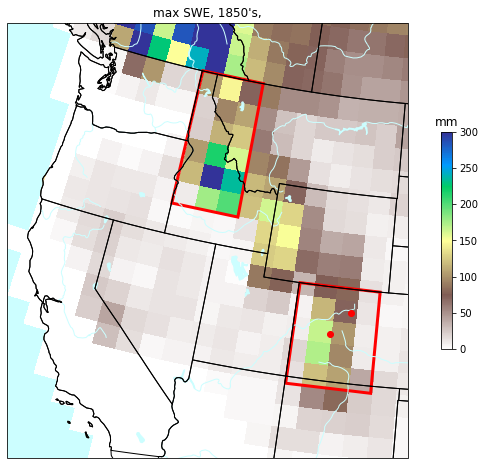

In [17]:
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

#plat2 = [40.0, 39 ]  
#plon2 = [(360-105.4), 253]

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([36.7,  36.7, 41, 41])
lon_corners = np.array([ (360-109), (360-104.5), (360-104.5), (360-109)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([43.3,  43.3, 49, 49])
lon_corners = np.array([ (360-117), (360-113.1), (360-113.1), (360-117)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, max snow from single ensemble in first decade ==
cf = ax.pcolormesh(ds.lon, ds.lat, ds.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
                   vmin=0,vmax=300, cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title(ds.H2OSNO.attrs['units'])
ax.set_title("max SWE, 1850's,");
plt.plot(plon, plat,
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.show()

### Calculate running mean for daily QRUNOFF to smooth results
- convert units to mm/d
- this block is kind of slow, 
- TODO, changing time chunks would make more efficient?

In [18]:
%%time 
s2d = 3600 * 24
dsPT['QRUNOFF'] = dsPT.QRUNOFF.chunk({"time": 1000}).rolling(
    time=21, center=True).mean()
dsPT['QRUNOFF'] = (dsPT['QRUNOFF'] *s2d).persist()
_ = wait(dsPT['QRUNOFF'])

dsREG['QRUNOFF'] = dsREG.QRUNOFF.chunk({"time": 1000}).rolling(
    time=21, center=True).mean()
dsREG['QRUNOFF'] = (dsREG['QRUNOFF'] *s2d).persist()
_ = wait(dsREG['QRUNOFF'])

# rename units
dsPT['QRUNOFF'].attrs['units'] = 'mm/d'
dsREG['QRUNOFF'].attrs['units'] = 'mm/d'

# Get chunks for Qrunnoff back to 'normal'
#dsPT['QRUNOFF'] = dsPT.QRUNOFF.chunk({"time": 1000})
#dsREG['QRUNOFF'] = dsREG.QRUNOFF.chunk({"time": 1000})

print('-- runoff smoothed --')

-- runoff smoothed --
CPU times: user 3min 52s, sys: 6.99 s, total: 3min 59s
Wall time: 3min 58s


-----
## Read in annual summary statistics

In [19]:
pathIN = '/glade/scratch/wwieder/VernalWindow/SnowStatsSWE*.nc'
ds = xr.open_mfdataset(pathIN,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
_ = wait(ds)
print(' -- Data read in -- ')

# Need to make last year of runoff variables zero
qvars = ['MaxQrun','MaxQrunDate','TotQrun','WinMELT','f_WinMELT']
for i in range(len(qvars)):
    ds[qvars[i]] = ds[qvars[i]].where(ds.time<2100)
    
# set day of first and last snow to day of water years
svars = ['LastSnowFree','FirstSnowFree']
for i in range(len(svars)):
    ds[svars[i]] = ds[svars[i]]+92
    ds[svars[i]] = ds[svars[i]].where(ds[svars[i]]<365, ds[svars[i]]-365)
    ds[svars[i]].attrs['long_name'] = svars[i]

ds['SnowFree'].attrs['long_name'] = "Snow free days"

#Mask out missing values (again)
ds = ds.where(ds['SnowFree']>=0)

 -- Data read in -- 


In [20]:
regions = ['Southern Rockies','Northern Rockies']
plat = [slice(36.7,41),
        slice(43.3,49) ]
plon = [slice((360-109),(360-104.5)),
        slice((360-117),(360-113.1))]
p=0
annREG = ds.sel(lat = plat[p], lon = plon[p]).mean(['lat','lon'])
p=1
annREG2 = ds.sel(lat = plat[p], lon = plon[p]).mean(['lat','lon'])
annREG = xr.concat([annREG,annREG2], dim='regions')
annREG = annREG.assign_coords({'regions': regions})

### Calculate annual summaries 
- ensemble means, stats and time of emergence

In [21]:
%%time
# ensemble mean of annual data
ds_ensMean = ds.mean('ens',skipna=True).compute()
ds_REGMean = annREG.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ds.std('ens',skipna=True).compute()
ds_REGStd = annREG.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

# add attributes
for ii in ds.data_vars:
    ds_ensMean[ii].attrs = ds[ii].attrs
    ds_ensStd[ii].attrs  = ds[ii].attrs
    ds_REGMean[ii].attrs = ds[ii].attrs
    ds_REGStd[ii].attrs  = ds[ii].attrs
    

CPU times: user 1.48 s, sys: 764 ms, total: 2.25 s
Wall time: 14.3 s


In [22]:
# ensemble mean and std over first 30 years
dsBase    = annREG.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = annREG.isel(time=slice(0,30)).std(dim=['time','ens']).compute()

# Then take mean and std over rolling mean
ds_roll = annREG.rolling(time=10, center=True).mean().compute()
roll_REGMean = ds_roll.mean('ens').compute()
roll_REGStd  = ds_roll.std('ens').compute()
#print('lat = '+str(plat[p])+' lon = '+str(plon[p]))

----
## Take regional ensemble mean of daily data 
- over region of N. and S. Rockies & plot

In [23]:
Ycoords = dsREG[fields[0]].mean(dim=['ens']).coords
Y, Ystd  = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords) 
Y2,Y2std = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)

for i in range(len(fields)):
    Y[fields[i]]    = dsREG[fields[i]].mean(dim='ens').compute()
    Ystd[fields[i]] = dsREG[fields[i]].std(dim='ens').persist()
        
year = np.unique(dsREG['time.year'].values)
print(' -- Finished regional ensemble means -- ')

# Shift to water year
shift = -273  #starts water year Oct 1
Y = Y.shift(time=shift)
Ystd = Ystd.shift(time=shift)

# shift time coords too
Y['time'] = Y.time.shift(time=shift)
Ystd['time'] = Ystd.time.shift(time=shift)
print('   ready to plot mean annual cycle of daily data')

 -- Finished regional ensemble means -- 
   ready to plot mean annual cycle of daily data


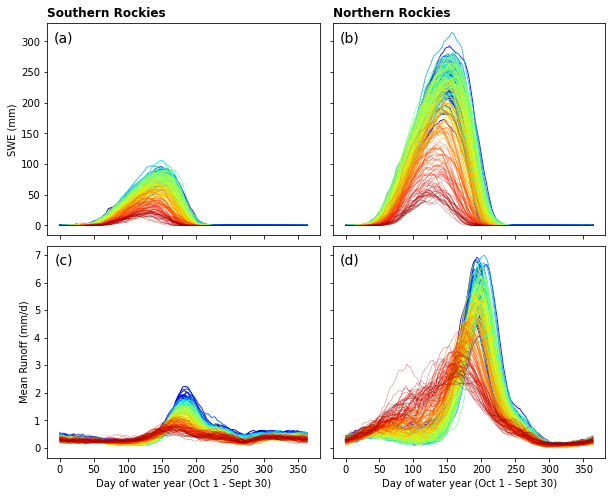

In [24]:
import matplotlib.colors as mcolors
nspan = 1
nyear = int(len(year)/nspan)
alpha = np.linspace(1.,0.5,nyear) 
lw = np.linspace(1.,0.5,nyear) 
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, 
                                sharey='row', sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(10,8))

color = iter(cm.jet(np.linspace(0,1,nyear)))
for i in range(nyear-1):
    #print(year[(i*nspan)])
    firstDay = 365*i*nspan
    lastDay = firstDay + 365
    y = Y.isel(time=slice(firstDay,lastDay) )
    y2 = Y2.isel(time=slice(firstDay,lastDay) )
    c = next(color)
    ax1.plot(y.H2OSNO.isel(regions=0),c=c,lw=lw[i],alpha=alpha[i]) 
    ax2.plot(y.H2OSNO.isel(regions=1),c=c,lw=lw[i],alpha=alpha[i]) 
    ax3.plot(y.QRUNOFF.isel(regions=0),c=c,lw=lw[i],alpha=alpha[i]) 
    ax4.plot(y.QRUNOFF.isel(regions=1),c=c,lw=lw[i],alpha=alpha[i]) 

ax1.set_title(regions[0], loc='left', 
              fontsize='large', fontweight='bold')
ax2.set_title(regions[1], loc='left', 
              fontsize='large', fontweight='bold')
ax1.set_ylabel('SWE (mm)') ;
ax3.set_ylabel('Mean Runoff (mm/d)') ;
ax3.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;

ax1.annotate('(a)', xy=(0.06, 0.93), xycoords=ax1.transAxes,
                ha='center', va='center',fontsize=14) 
ax2.annotate('(b)', xy=(0.06, 0.93), xycoords=ax2.transAxes,
                ha='center', va='center',fontsize=14) 
ax3.annotate('(c)', xy=(0.06, 0.93), xycoords=ax3.transAxes,
                ha='center', va='center',fontsize=14) 
ax4.annotate('(d)', xy=(0.06, 0.93), xycoords=ax4.transAxes,
                ha='center', va='center',fontsize=14);

<Figure size 1296x432 with 0 Axes>

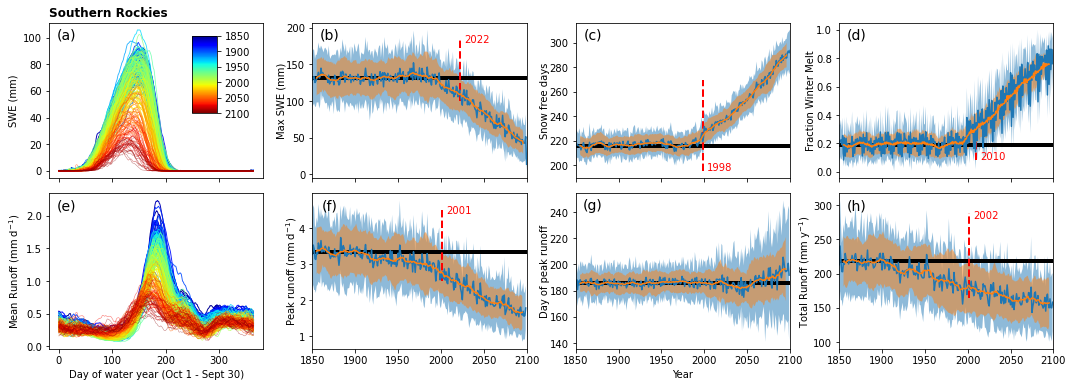

<Figure size 1296x432 with 0 Axes>

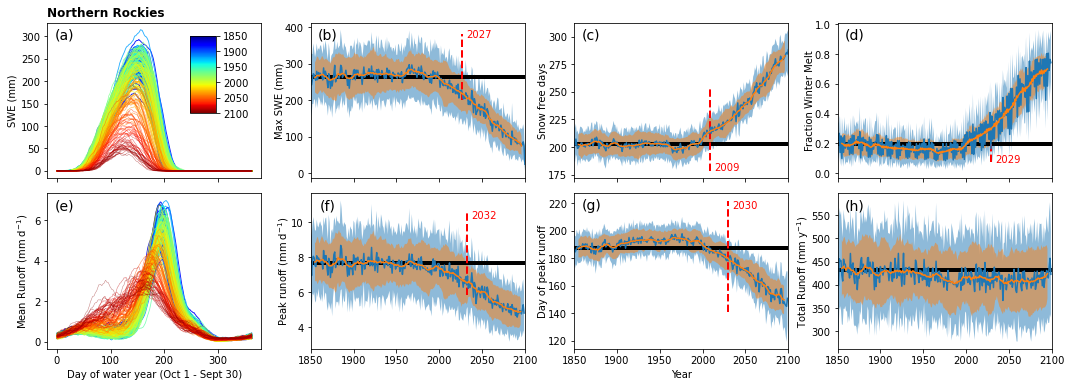

In [25]:
day_vars = ['H2OSNO','QRUNOFF']
in_vars = ['MaxSnow','SnowFree','f_WinMELT',
           'MaxQrun','MaxQrunDate','TotQrun']
sno_vars = ['Max SWE (mm)', 'Snow free days', 'Fraction Winter Melt',
            'Peak runoff (mm $\mathregular{d^{-1}}$)',
            'Day of peak runoff',
            'Total Runoff (mm $\mathregular{y^{-1}}$)']
sno_trend = ['neg','pos','pos',
             'neg','neg','neg']
ID = ['(b)','(c)','(d)','(f)','(g)','(h)']

#select the region to plot here
for p in range(len(regions)):
    plt.figure(figsize=[18,6])
    fig, axs = plt.subplots(2,4, sharex='col',
                            gridspec_kw={'wspace': 0.23, 'hspace': 0.1},
                            figsize=(18,6))


    nspan = 1
    nyear = int(len(year)/nspan)
    alpha = np.linspace(1.,0.5,nyear) 
    lw = np.linspace(1.,0.5,nyear) 

    i,j = 0,0
    ## Plot chagnes in the annual cycle
    for i in range(2):
        color = iter(cm.jet(np.linspace(0,1,nyear)))
        for yr in range(nyear-1):
            #print(year[(i*nspan)])
            firstDay = 365*yr*nspan
            lastDay = firstDay + 365
            #x = Y.time.isel(time=slice(firstDay,lastDay))
            y = Y.isel(regions=p,time=slice(firstDay,lastDay))

            c = next(color)
            axs[i,j].plot(y[day_vars[i]],c=c,lw=lw[yr],alpha=alpha[yr]) 

        if i == 0: 
            axs[i,j].set_title(regions[p],
                               loc='left', fontsize='large', fontweight='bold')
            axs[i,j].set_ylabel('SWE (mm)') 
            axs[i,j].annotate('(a)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

        else:
            axs[i,j].set_ylabel('Mean Runoff (mm $\mathregular{d^{-1}}$)') ;
            axs[i,j].set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
            axs[i,j].annotate('(e)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

    ### Plot time series of annual metrics
    # move counter for panel
    i,j = 0,1
    for v in range(len(sno_vars)):
        # ens mean
        x = ds_REGMean.time
        y = ds_REGMean[in_vars[v]].isel(regions=p)
        y2 = ds_REGStd[in_vars[v]].isel(regions=p)

        axs[i,j].plot(x, y, '-')
        axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
        axs[i,j].set_ylabel(sno_vars[v],labelpad=0.) ;

        # rolling ensemble mean
        x = roll_REGMean.time
        y = roll_REGMean[in_vars[v]].isel(regions=p)
        y2= roll_REGStd[in_vars[v]].isel(regions=p)
        axs[i,j].plot(x, y)
        axs[i,j].set_xlim(1850,2100)
        axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

        # baseline
        axs[i,j].hlines(dsBase[in_vars[v]].isel(regions=p),
                        1850, 2100, colors='k',lw=4) ;

        # find last day when roll mean - 2 std < baseline
        if sno_trend[v] == 'pos':  # variables w/ positive trend:
            test = y - 2*y2
            test = test.where(test<dsBase[in_vars[v]].isel(regions=p)).dropna('time')
        else:
            test = y + 2*y2
            test = test.where(test>dsBase[in_vars[v]].isel(regions=p)).dropna('time')

        ToE = test.time.isel(time=-1)
        #draw ToE lines
        if ToE <2095:
            if sno_trend[v] == 'pos': 
                axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.25,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
            else: 
                axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.max()*1.07, ToE.values,color='r')
        #add panel label
        axs[i,j].annotate(ID[v], xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 
        if v == 4:
            axs[i,j].set_xlabel('Year') ;

        # move counter for panel
        j = j+1
        if j == 4:
            i = i+1
            j = 1 ;


    # Fake a ScalarMappable so you can display a colormap
    nvalues=nyear
    cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                                cm.jet(np.linspace(0,1,(nyear-1))))
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    #Specifying figure coordinates works fine:
    fig_coord = [0.235,0.67,0.02,0.18]
    cbar_ax = fig.add_axes(fig_coord)

    # tick mark levels
    clevs = [1850,1900,1950,2000,2050,2100]

    fig.colorbar(sm,cax=cbar_ax,
                 orientation='vertical', 
                 ticks=clevs).ax.invert_yaxis() ;


## Plot ensemble mean for individual points
- Compute ensemble statistics on daily data


In [26]:
Ycoords = dsPT[fields[0]].mean(dim=['ens']).coords
Y,    Ystd = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)
Ymin, Ymax = xr.Dataset(coords=Ycoords), xr.Dataset(coords=Ycoords)

for i in range(len(fields)):
    print('starting '+ fields[i])
    Y[fields[i]]    = dsPT[fields[i]].mean(dim=['ens']).compute()
    Ystd[fields[i]] = dsPT[fields[i]].std(dim=['ens']).persist()
    
    # how to fine the 'appropraite high and low values in each year for each ensemble?  
    # Here just taking the min/max acrros all ensembles'
    #Ymin[fields[i]] = dsPT[fields[i]].min(dim=['ens']).persist()
    #Ymax[fields[i]] = dsPT[fields[i]].max(dim=['ens']).persist() 

year = np.unique(dsPT['time.year'].values)
print(' -- Finished ensemble means for points -- ')

starting QRUNOFF
starting H2OSNO
 -- Finished ensemble means for points -- 


#### Shift results to water year, **just do this once!**
- `WaterYear` protects against doing this multiple times

In [27]:
print(WaterYear)
if WaterYear == False:
    shift = -273  #starts water year Oct 1
    Y = Y.shift(time=shift)
    Ystd = Ystd.shift(time=shift)
    #Ymin = Ymin.shift(time=shift)
    #Ymax = Ymax.shift(time=shift)

    # shift time coords too
    Y['time'] = Y.time.shift(time=shift)
    Ystd['time'] = Ystd.time.shift(time=shift)
    #Ymin['time'] = Ymin.time.shift(time=shift)
    #Ymax['time'] = Ymax.time.shift(time=shift)
    WaterYear=True

False


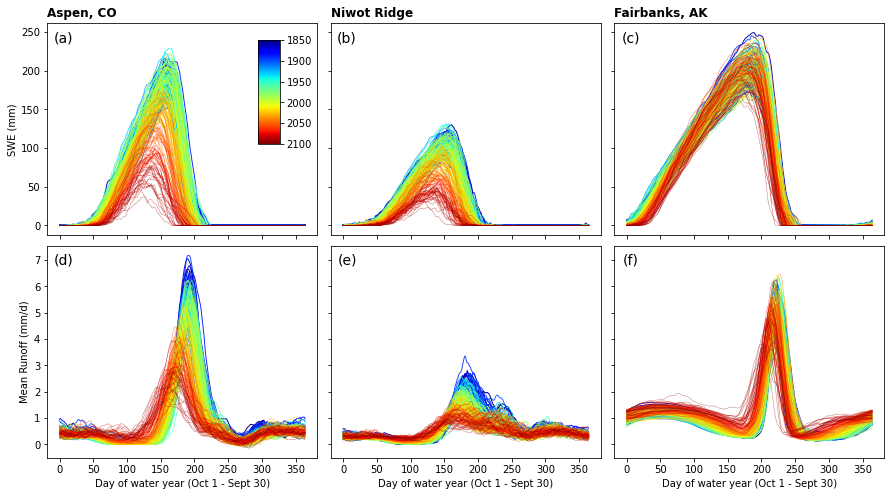

In [29]:
nspan = 1
nyear = int(len(year)/nspan)
alpha = np.linspace(1.,0.5,nyear) 
lw = np.linspace(1.,0.5,nyear) 
fig, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(2, 3, 
                                sharey='row', sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(15,8))

for h in range(len(site)):
    color = iter(cm.jet(np.linspace(0,1,nyear)))
    for i in range(nyear-1):
        #print(year[(i*nspan)])
        firstDay = 365*i*nspan
        lastDay = firstDay + 365
        #x = Y.time.isel(time=slice(firstDay,lastDay))
        y = Y.isel(time=slice(firstDay,lastDay), 
                   lat=h,lon=h)
        c = next(color)
        if h == 0: 
            ax1.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax4.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
        if h == 1:
            ax2.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax5.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
        if h == 2:
            ax3.plot(y.H2OSNO,c=c,lw=lw[i],alpha=alpha[i]) 
            ax6.plot(y.QRUNOFF,c=c,lw=lw[i],alpha=alpha[i]) 
#months = mdates.MonthLocator((10,11,12,1,2,3,4,5,6,7,8,9))  # every month   
#fmt = mdates.DateFormatter('%b')
#ax.xaxis.set_major_locator(months)
#ax.xaxis.set_major_formatter(fmt)
ax1.set_title(site[0], loc='left', 
              fontsize='large', fontweight='bold')
ax1.set_ylabel('SWE (mm)') ;
ax2.set_title(site[1], loc='left', 
              fontsize='large', fontweight='bold')
ax3.set_title(site[2], loc='left', 
              fontsize='large', fontweight='bold')
ax4.set_ylabel('Mean Runoff (mm/d)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax5.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
ax6.set_xlabel('Day of water year (Oct 1 - Sept 30)') ;

ax1.annotate('(a)', xy=(0.06, 0.93), xycoords=ax1.transAxes,
                ha='center', va='center',fontsize=14) 
ax2.annotate('(b)', xy=(0.06, 0.93), xycoords=ax2.transAxes,
                ha='center', va='center',fontsize=14) 
ax3.annotate('(c)', xy=(0.06, 0.93), xycoords=ax3.transAxes,
                ha='center', va='center',fontsize=14) 
ax4.annotate('(d)', xy=(0.06, 0.93), xycoords=ax4.transAxes,
                ha='center', va='center',fontsize=14) 
ax5.annotate('(e)', xy=(0.06, 0.93), xycoords=ax5.transAxes,
                ha='center', va='center',fontsize=14) 
ax6.annotate('(f)', xy=(0.06, 0.93), xycoords=ax6.transAxes,
                ha='center', va='center',fontsize=14) 

# Fake a ScalarMappable so you can display a colormap
nvalues=nyear
cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                            cm.jet(np.linspace(0,1,(nyear-1))))
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#Specifying figure coordinates works fine:
fig_coord = [0.32,0.67,0.02,0.18]
cbar_ax = fig.add_axes(fig_coord)

# tick mark levels
clevs = [1850,1900,1950,2000,2050,2100]

fig.colorbar(sm,cax=cbar_ax,
             orientation='vertical', 
             ticks=clevs).ax.invert_yaxis() ;

#### Given chagnes in snowmelt, likley worth looking at runnoff timing & magnitude too
- TODO, add months to x-axis of right plots, starting on Oct-1

## Plot annual cycle and annual trends with TOE calculations for individual grids
- read in data calculated in VernalWindow script
- calculate ensemble rolling means, SD 

In [32]:
# ensemble mean and std over first 30 years
dsBase    = ds.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ds.isel(time=slice(0,30)).std(dim=['time','ens']).compute()

# Then take mean and std over rolling mean
ds_roll = ds.rolling(time=10, center=True).mean().compute()
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
#print('lat = '+str(plat[p])+' lon = '+str(plon[p]))

<Figure size 1296x432 with 0 Axes>

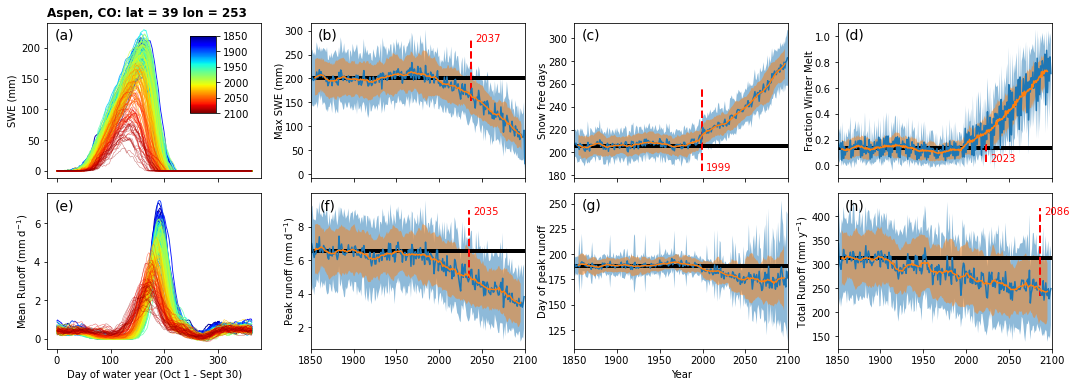

<Figure size 1296x432 with 0 Axes>

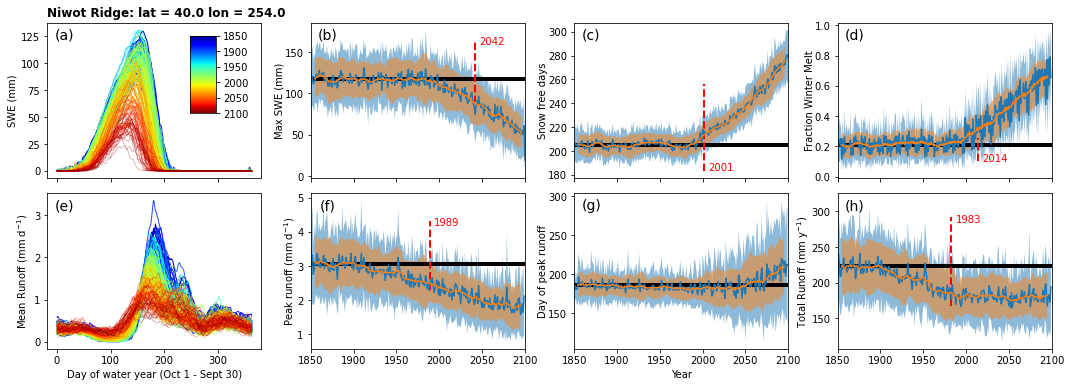

<Figure size 1296x432 with 0 Axes>

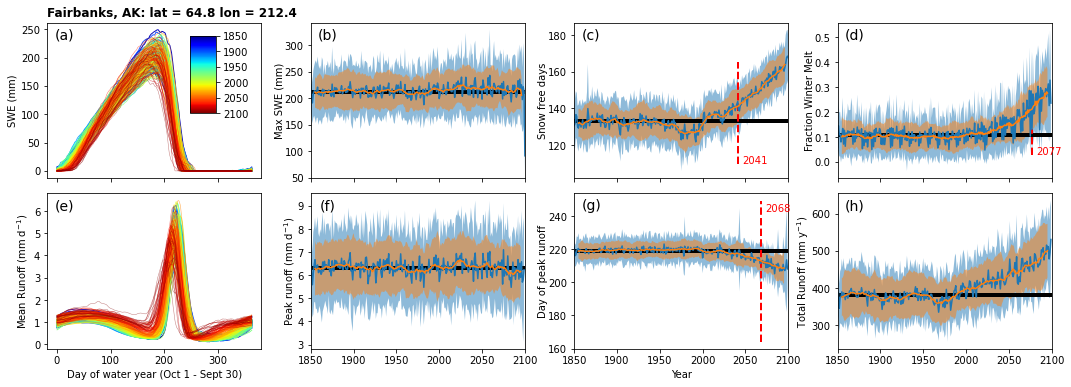

In [33]:
'''
plat = [40.45, 44.66 ,48.5]  
plon = [360-105.75, 360-111.09, 360-113.97]
site = ['Rocky Mountain NP','Yellowstone NP', 'Glacier NP']
'''

# This is a little far west for NWT, but gets a grid with more snow.
plat = [39 , 40.0, 64.8]  
plon = [253, 254., 212.4]
site = ['Aspen, CO','Niwot Ridge', 'Fairbanks, AK']

day_vars = ['H2OSNO','QRUNOFF']
in_vars = ['MaxSnow','SnowFree','f_WinMELT',
           'MaxQrun','MaxQrunDate','TotQrun']
sno_vars = ['Max SWE (mm)', 'Snow free days', 'Fraction Winter Melt',
            'Peak runoff (mm $\mathregular{d^{-1}}$)',
            'Day of peak runoff',
            'Total Runoff (mm $\mathregular{y^{-1}}$)']
sno_trend = ['neg','pos','pos',
             'neg','neg','neg']
ID = ['(b)','(c)','(d)','(f)','(g)','(h)']

#select the site to plot here
for p in range(len(site)):
    plt.figure(figsize=[18,6])
    fig, axs = plt.subplots(2,4, sharex='col',
                            gridspec_kw={'wspace': 0.23, 'hspace': 0.1},
                            figsize=(18,6))


    nspan = 1
    nyear = int(len(year)/nspan)
    alpha = np.linspace(1.,0.5,nyear) 
    lw = np.linspace(1.,0.5,nyear) 

    i,j = 0,0
    ## Plot chagnes in the annual cycle
    for i in range(2):
        color = iter(cm.jet(np.linspace(0,1,nyear)))
        for yr in range(nyear-1):
            #print(year[(i*nspan)])
            firstDay = 365*yr*nspan
            lastDay = firstDay + 365
            #x = Y.time.isel(time=slice(firstDay,lastDay))
            y = Y.isel(time=slice(firstDay,lastDay), 
                       lat=p,lon=p)
            c = next(color)
            axs[i,j].plot(y[day_vars[i]],c=c,lw=lw[yr],alpha=alpha[yr]) 

        if i == 0: 
            axs[i,j].set_title(site[p]+': lat = '+str(plat[p])+' lon = '+str(plon[p]), 
                               loc='left', fontsize='large', fontweight='bold')
            axs[i,j].set_ylabel('SWE (mm)') 
            axs[i,j].annotate('(a)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

        else:
            axs[i,j].set_ylabel('Mean Runoff (mm $\mathregular{d^{-1}}$)') ;
            axs[i,j].set_xlabel('Day of water year (Oct 1 - Sept 30)') ;
            axs[i,j].annotate('(e)', xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 

    ### Plot time series of annual metrics
    # move counter for panel
    i,j = 0,1
    for v in range(len(sno_vars)):
        # ens mean
        x = ds_ensMean.time
        y = ds_ensMean[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        y2 = ds_ensStd[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')

        axs[i,j].plot(x, y, '-')
        axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
        axs[i,j].set_ylabel(sno_vars[v],labelpad=0.) ;

        # rolling ensemble mean
        x = roll_ensMean.time
        y = roll_ensMean[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        y2= roll_ensStd[in_vars[v]].sel(lat = plat[p], lon = plon[p], method='nearest')
        axs[i,j].plot(x, y)
        axs[i,j].set_xlim(1850,2100)
        axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

        # baseline
        axs[i,j].hlines(dsBase[in_vars[v]].sel(
            lat = plat[p], lon = plon[p], method='nearest'), 
                        1850, 2100, colors='k',lw=4) ;

        # find last day when roll mean - 2 std < baseline
        if sno_trend[v] == 'pos':  # variables w/ positive trend:
            test = y - 2*y2
            test = test.where(test<dsBase[in_vars[v]].sel(
                lat = plat[p], lon = plon[p], method='nearest')).dropna('time')
        else:
            test = y + 2*y2
            test = test.where(test>dsBase[in_vars[v]].sel(
                lat = plat[p], lon = plon[p], method='nearest')).dropna('time')

        ToE = test.time.isel(time=-1)
        #draw ToE lines
        if ToE <2095:
            if sno_trend[v] == 'pos': 
                axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.25,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
            else: 
                axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                                lw=2,linestyles='dashed') ;
                axs[i,j].text(ToE+5, test.max()*1.07, ToE.values,color='r')
        #add panel label
        axs[i,j].annotate(ID[v], xy=(0.08, 0.92), xycoords=axs[i,j].transAxes,
                        ha='center', va='center',fontsize=14) 
        if v == 4:
            axs[i,j].set_xlabel('Year') ;

        # move counter for panel
        j = j+1
        if j == 4:
            i = i+1
            j = 1 ;


    # Fake a ScalarMappable so you can display a colormap
    nvalues=nyear
    cmap, norm = mcolors.from_levels_and_colors(range(1850,2101), 
                                                cm.jet(np.linspace(0,1,(nyear-1))))
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    #Specifying figure coordinates works fine:
    fig_coord = [0.235,0.67,0.02,0.18]
    cbar_ax = fig.add_axes(fig_coord)

    # tick mark levels
    clevs = [1850,1900,1950,2000,2050,2100]

    fig.colorbar(sm,cax=cbar_ax,
                 orientation='vertical', 
                 ticks=clevs).ax.invert_yaxis() ;

-------------------
# End of working code...

In [25]:
#print(y.TSOI)
#plt.plot(y.QRUNOFF)
#print(nyear)
print(Y)

<xarray.Dataset>
Dimensions:  (lat: 3, lon: 3, time: 91616)
Coordinates:
  * lon      (lon) float32 246.2 248.8 253.8
  * lat      (lat) float32 48.53 44.76 40.05
  * time     (time) object 1850-10-01 00:00:00 1850-10-02 00:00:00 ... nan nan
Data variables:
    QRUNOFF  (time, lat, lon) float64 0.03882 0.449 0.2786 ... nan nan nan
    H2OSNO   (time, lat, lon) float32 0.0 0.0 0.0 1.994e-09 ... nan nan nan nan


1851


AttributeError: 'Dataset' object has no attribute 'SNOWDP'

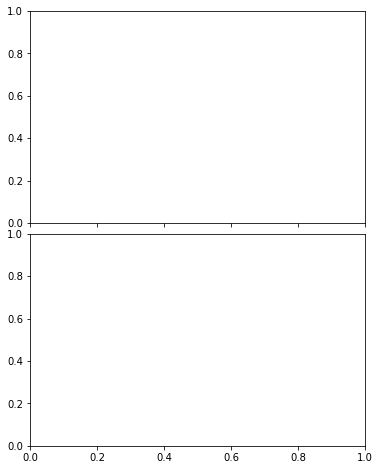

In [26]:
nspan =25
nyear = int(len(year)/nspan)
color = iter(cm.jet(np.linspace(0,1,(nyear))) )

fig, (ax2, ax4) = plt.subplots(2, 1, sharex='col',
                                gridspec_kw={'wspace': 0.05, 'hspace':0.05},
                                figsize=(6,8))

for i in range(nyear):
    print(year[i*nspan]+1)
    firstDay = 365*nspan*i+365
    lastDay = firstDay + 365
    x = Y.time.isel(time=slice(firstDay,lastDay))
    x2 = range(0,365)
    y = Y.isel(time=slice(firstDay,lastDay)).isel(lat=1,lon=1)
    ystd = Ystd.isel(time=slice(firstDay,lastDay)).isel(lat=1,lon=1)
    c = next(color)
    # snow depth plots
    #ax1.plot(x,ymin.SNOWDP,c=c) 
    if i == 0 or i == nyear-1:
        ax2.plot(x2, y.H2OSNO,c=c) 
        ax2.fill_between(x2, y.H2OSNO-ystd.H2OSNO, 
                     y.H2OSNO+ystd.H2OSNO, alpha=0.2,color=c)
    # soil temperature plots
    #ax4.set_ylim(top=8, bottom=-6)
        ax4.plot(x2, y.QRUNOFF,color=c) 
        ax4.fill_between(x2, y.QRUNOFF+ystd.QRUNOFF, 
                             y.QRUNOFF-ystd.QRUNOFF, alpha=0.2,color=c)
    
ax2.set_title('Ensemble mean, lat = '+str(plat)+', lon = '+str(plon), 
              loc='left', fontsize='large', fontweight='bold')
ax2.set_ylabel('SWE (mm)') ;
ax4.set_ylabel('Runnoff (mm/d)') ;
ax4.set_xlabel('Day of water year (Oct 1 - Sept 30)') 
ax2.legend([year[0],year[-1]], loc='upper right') ;

In [ ]:
from scipy import signal
powerVar = 'QRUNOFF'
sig = dsPT[powerVar].isel(
    ens=0, lat=0,lon=0, time=slice(365,3650)).values

freqs, times, spectrogram = signal.spectrogram(sig,nperseg=365)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

print(sig)

In [66]:
y = np.arange(0.,len(sig),1)
print(len(sig))
len(y)

3285


3285

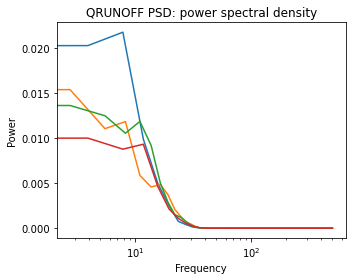

In [85]:
# plot power spectra of runoff

sig2 = dsPT[powerVar].isel(
    ens=0, lat=0,lon=0, time=slice(-3650,-365))
sig3 = dsPT[powerVar].isel(
    ens=1, lat=0,lon=0, time=slice(-3650,-365))
freqs, psd = signal.welch(sig, fs=1000)
freqs2, psd2 = signal.welch(sig2, fs=1000,nperseg=365)
freqs3, psd3 = signal.welch(sig3, fs=1000,nperseg=365)
freqs3b, psd3b = signal.welch(sig3, fs=1000)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.semilogx(freqs2, psd2)
plt.semilogx(freqs3, psd3)
plt.semilogx(freqs3b, psd3b)
plt.title(powerVar+' PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [80]:
freqs

array([0.        , 0.00273973, 0.00547945, 0.00821918, 0.0109589 ,
       0.01369863, 0.01643836, 0.01917808, 0.02191781, 0.02465753,
       0.02739726, 0.03013699, 0.03287671, 0.03561644, 0.03835616,
       0.04109589, 0.04383562, 0.04657534, 0.04931507, 0.05205479,
       0.05479452, 0.05753425, 0.06027397, 0.0630137 , 0.06575342,
       0.06849315, 0.07123288, 0.0739726 , 0.07671233, 0.07945205,
       0.08219178, 0.08493151, 0.08767123, 0.09041096, 0.09315068,
       0.09589041, 0.09863014, 0.10136986, 0.10410959, 0.10684932,
       0.10958904, 0.11232877, 0.11506849, 0.11780822, 0.12054795,
       0.12328767, 0.1260274 , 0.12876712, 0.13150685, 0.13424658,
       0.1369863 , 0.13972603, 0.14246575, 0.14520548, 0.14794521,
       0.15068493, 0.15342466, 0.15616438, 0.15890411, 0.16164384,
       0.16438356, 0.16712329, 0.16986301, 0.17260274, 0.17534247,
       0.17808219, 0.18082192, 0.18356164, 0.18630137, 0.1890411 ,
       0.19178082, 0.19452055, 0.19726027, 0.2       , 0.20273

ValueError: x and y can be no greater than 2-D, but have shapes (91616,) and (91616, 3, 3)

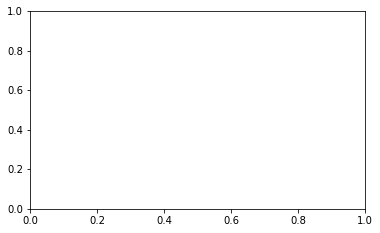

In [31]:
import matplotlib.dates as mdates

# determine the water year
# !! This approach puts Octoberr 1 as DOY=1, but then the previous Jan moves to then end of the year
### try using shift instead?

dsPT['day_water_year'] = xr.where(dsPT.time.dt.dayofyear<=274,dsPT.time.dt.dayofyear+(365-273),dsPT.time.dt.dayofyear-273)
MonthShift = (xr.where(dsPT.time.dt.month<=10,dsPT.time.dt.month+3,dsPT.time.dt.month-9))

plt.figure(figsize=[6,8])

plt.subplot(2,1,1)
plt.plot(dsPT['day_water_year'], dsPT.SNOWDP.mean(dim=['ens']))

plt.subplot(2,1,2)
plt.plot(dsPT['day_water_year'], dsPT.QRUNOFF.mean(dim=['ens']))

### unsure how to adjust dates for water year (Oct-Sept)
tempTime = pd.date_range('2001-10-01', '2002-09-30', freq='m')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
print(tempTime)
#X = plt.gca().xaxis
#X.set_major_locator(locator)
# Specify formatter
#X.set_major_formatter(fmt)
plt.show();

In [32]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-04-21

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 6fa47a8abefc2a75f46e86c2c7583c89041b5c88

Git repo: https://github.com/wwieder/cesm-lens.git

Git branch: main

dask      : 2021.2.0
pandas    : 1.2.3
xarray    : 0.17.0
numpy     : 1.20.1
cartopy   : 0.18.0
matplotlib: 3.3.4
numba     : 0.52.0
cftime    : 1.4.1
scipy     : 1.6.0



In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
